In [1]:
# ============================================
# 📦 Cell 1 — Mount Drive & Install Packages
# What: Ensure libraries are available and dataset accessible
# Why: Prepare runtime environment
# ============================================

from google.colab import drive
drive.mount('/content/drive')

!pip install -q transformers datasets sentence-transformers accelerate tokenizers wordcloud optuna
!pip install -q transformers[sentencepiece]


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 29.2 MB/s eta 0:00:00


In [2]:
# ============================================
# ⚙️ Cell 2 — Imports and Global Config
# What: Load all libraries and define constants
# Why: Keep imports organized for clarity and reproducibility
# ============================================

import os, json, joblib, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS

SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)


Device: cuda


In [3]:
# ============================================
# 🧾 Cell 3 — Load Dataset & Generate Weak Labels (if needed)
# What: Load Facebook dataset and create emotion labels using pretrained model
# Why: Provide weak supervision for initial analysis (no fine-tuning)
# ============================================

DATA_PATH = "/content/drive/MyDrive/Facebook_data_txt.csv"
df = pd.read_csv(DATA_PATH)
print("Original df shape:", df.shape)

df = df.dropna(subset=['text']).copy()
df['text'] = df['text'].astype(str).str.strip()
df = df[df['text'] != ""].reset_index(drop=True)

if "emotion" not in df.columns:
    print("No 'emotion' column found → generating weak labels using pretrained model...")
    emo_model_id = "j-hartmann/emotion-english-distilroberta-base"
    emo_pipe = pipeline("text-classification", model=emo_model_id,
                        device=0 if device == "cuda" else -1, return_all_scores=False)

    def batch_predict(texts, batch_size=32):
        labels = []
        for i in range(0, len(texts), batch_size):
            results = emo_pipe(texts[i:i+batch_size])
            labels.extend([r["label"].lower() for r in results])
        return labels

    df["emotion"] = batch_predict(df["text"].tolist(), batch_size=32)
    print("✅ Generated weak labels using pretrained model.")

df.to_csv(os.path.join(ARTIFACT_DIR, "facebook_with_emotion.csv"), index=False)
print("\nSaved dataset with emotion labels to:", os.path.join(ARTIFACT_DIR, "facebook_with_emotion.csv"))
print("\nEmotion distribution:\n", df["emotion"].value_counts())


Original df shape: (5000, 11)
No 'emotion' column found → generating weak labels using pretrained model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Generated weak labels using pretrained model.

Saved dataset with emotion labels to: artifacts/facebook_with_emotion.csv

Emotion distribution:
 emotion
neutral     2605
joy          975
sadness      766
fear         374
surprise     239
anger         41
Name: count, dtype: int64


In [ ]:
# ============================================
# 🔀 Cell 4 — Train/Validation/Test Split
# What: Create stratified splits for robust evaluation
# Why: Maintain balanced distribution of emotion classes across splits
# Note: Using ALL emotion classes for comprehensive detection
# ============================================

# Filter to keep only emotions with sufficient samples (optional, can remove)
# emotion_counts = df["emotion"].value_counts()
# min_samples = 50  # Adjust threshold as needed
# valid_emotions = emotion_counts[emotion_counts >= min_samples].index
# df = df[df["emotion"].isin(valid_emotions)].reset_index(drop=True)

train_df, test_df = train_test_split(
    df[["text", "emotion"]],
    test_size=0.20, random_state=SEED, stratify=df["emotion"]
)
train_df, val_df = train_test_split(
    train_df, test_size=0.10, random_state=SEED, stratify=train_df["emotion"]
)

le = LabelEncoder()
y_train = le.fit_transform(train_df["emotion"])
y_val = le.transform(val_df["emotion"])
y_test = le.transform(test_df["emotion"])
label_names = list(le.classes_)
num_labels = len(label_names)

print("Labels:", label_names)
print("Number of emotion classes:", num_labels)
print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))

Labels: ['anger', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
Train/Val/Test sizes: 3600 400 1000


In [5]:
# ============================================
# 🧠 Cell 5 — Baseline Model (TF-IDF + LinearSVC)
# What: Train a simple but strong linear model
# Why: Establish a non-transformer baseline for comparison & publication
# ============================================

from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    lowercase=True,
    token_pattern=r"(?u)\b\w[\w'-]*\b"
)

base_svc = LinearSVC(class_weight="balanced", random_state=SEED, max_iter=5000)
calibrated = CalibratedClassifierCV(estimator=base_svc, cv=3, method="sigmoid")

svm_pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf", calibrated)
])

print("Training SVM baseline...")
svm_pipe.fit(train_df["text"], y_train)

pred_val = svm_pipe.predict(val_df["text"])
pred_test = svm_pipe.predict(test_df["text"])

print("\nValidation — Accuracy:", round(accuracy_score(y_val, pred_val),3),
      "Macro-F1:", round(f1_score(y_val, pred_val, average="macro"),3))
print("Test — Accuracy:", round(accuracy_score(y_test, pred_test),3),
      "Macro-F1:", round(f1_score(y_test, pred_test, average="macro"),3))

print("\nClassification Report (Test):")
print(classification_report(y_test, pred_test, target_names=label_names))

joblib.dump(svm_pipe, os.path.join(ARTIFACT_DIR, "emotion_svm_pipeline.joblib"))
joblib.dump(le, os.path.join(ARTIFACT_DIR, "emotion_label_encoder.joblib"))
pd.Series(label_names).to_csv(os.path.join(ARTIFACT_DIR, "emotion_label_names.csv"), index=False)
print("✅ Artifacts saved.")


Training SVM baseline...

Validation — Accuracy: 0.973 Macro-F1: 0.959
Test — Accuracy: 0.981 Macro-F1: 0.961

Classification Report (Test):
              precision    recall  f1-score   support

       anger       0.89      1.00      0.94         8
        fear       0.93      0.89      0.91        75
         joy       0.97      0.99      0.98       195
     neutral       1.00      0.99      0.99       521
     sadness       0.97      0.99      0.98       153
    surprise       0.98      0.94      0.96        48

    accuracy                           0.98      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.98      0.98      0.98      1000

✅ Artifacts saved.


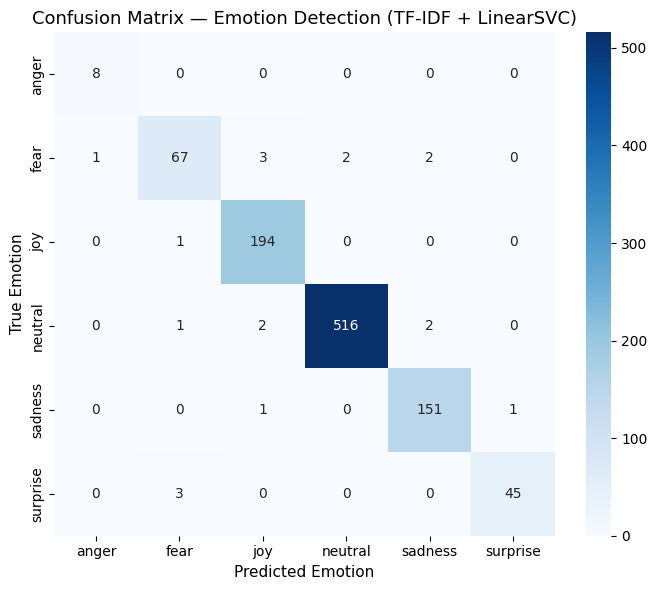

✅ Confusion matrix generated and saved.


In [6]:
# ============================================
# 📊 Confusion Matrix — Emotion Detection (Test Set)
# What: Visualize classification reliability per emotion class
# Why: Complements quantitative metrics for publication
# ============================================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Load trained artifacts
svm_pipe = joblib.load(os.path.join(ARTIFACT_DIR, "emotion_svm_pipeline.joblib"))
label_enc = joblib.load(os.path.join(ARTIFACT_DIR, "emotion_label_encoder.joblib"))

# Predict on test data
y_pred_test = svm_pipe.predict(test_df["text"])
cm = confusion_matrix(y_test, y_pred_test)
labels = label_enc.classes_

# Plot confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Emotion", fontsize=11)
plt.ylabel("True Emotion", fontsize=11)
plt.title("Confusion Matrix — Emotion Detection (TF-IDF + LinearSVC)", fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "emotion_confusion_matrix.png"), dpi=200)
plt.show()

print("✅ Confusion matrix generated and saved.")


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last

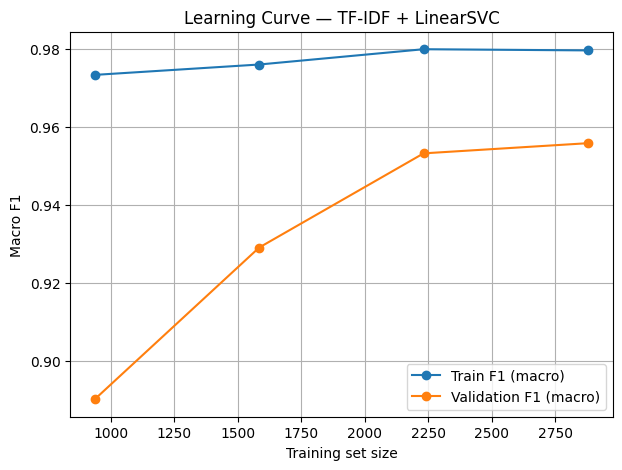

In [7]:
# ============================================
# 📈 Cell 6 — Learning Curve Diagnostics
# What: Detect underfitting or overfitting patterns
# Why: Support analysis and visual evidence for paper
# ============================================

train_sizes, train_scores, val_scores = learning_curve(
    svm_pipe,
    train_df["text"], y_train,
    cv=5,
    scoring="f1_macro",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Train F1 (macro)")
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label="Validation F1 (macro)")
plt.xlabel("Training set size"); plt.ylabel("Macro F1")
plt.title("Learning Curve — TF-IDF + LinearSVC")
plt.legend(); plt.grid(True)
plt.show()


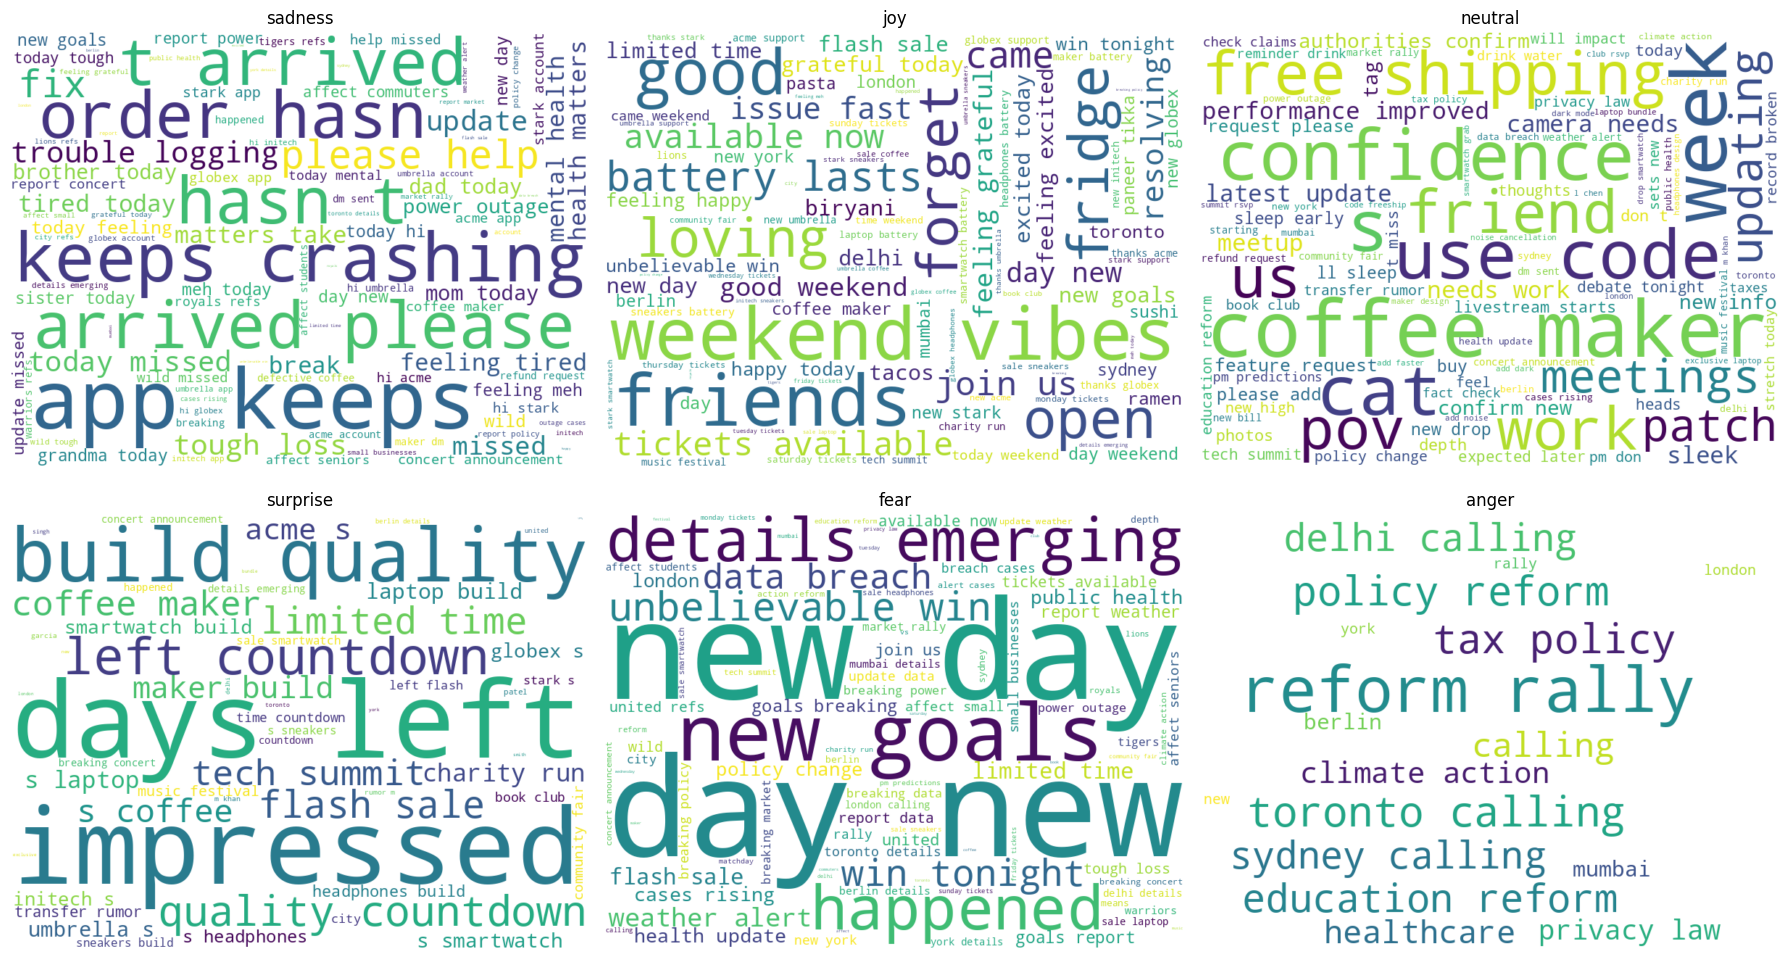

✅ Wordclouds generated and saved.


In [8]:
# ============================================
# ☁️ Cell 7 — Word Clouds per Emotion
# What: Visualize dominant terms in each emotion class
# Why: Enhance interpretability and add visual figures for paper
# ============================================

def clean_text_simple(text):
    t = re.sub(r'http\S+', '', str(text))
    t = re.sub(r'@\w+', '', t)
    t = re.sub(r'#\w+', '', t)
    t = re.sub(r'[^a-zA-Z\s]', ' ', t)
    return t.lower().strip()

df["cleaned_text"] = df["text"].apply(clean_text_simple)

emotions = df["emotion"].unique().tolist()
fig, axes = plt.subplots(2, 3, figsize=(18,10))
axes = axes.flatten()
for i, e in enumerate(emotions[:6]):
    text_e = " ".join(df[df["emotion"] == e]["cleaned_text"].tolist())
    if text_e.strip():
        wc = WordCloud(width=800, height=600, background_color='white',
                       stopwords=set(STOPWORDS), max_words=100).generate(text_e)
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(e)
    else:
        axes[i].text(0.5, 0.5, f"No text for {e}", ha="center")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "emotion_wordclouds.png"), dpi=200)
plt.show()

print("✅ Wordclouds generated and saved.")


Figure 3: Sample posts from Emotion Dataset (D2)


,text,emotion
0,Mental health matters. Take a break. 🎉,sadness
1,Having trouble logging into my Stark account—a...,sadness
2,When you open the fridge and forget why you ca...,joy
3,In-depth: What market rally means for New York.,neutral
4,Transfer rumor: J. Smith to City?,surprise



Table 1: Emotion Class Distribution


,Emotion Class,Count,Percent
0,neutral,2605,52.10
1,joy,975,19.50
2,sadness,766,15.32
3,fear,374,7.48
4,surprise,239,4.78
5,anger,41,0.82


/tmp/ipython-input-235821557.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emo_counts.index, y=emo_counts.values, palette="pastel")


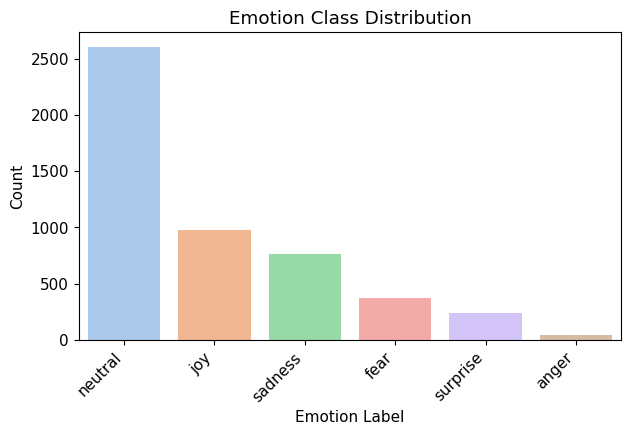


Table 2: Emotion Dataset Split Summary


,Split,Samples
0,Train,3600
1,Validation,400
2,Test,1000


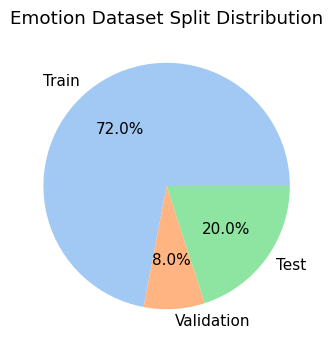

In [9]:
# ============================================
# 📊 Cell 8 — Visualization and Summary
# What: Summarize dataset class balance and split sizes
# Why: For paper figures (e.g., Table 1, Figure 3)
# ============================================

plt.rcParams['figure.figsize'] = (7,4)
plt.rcParams['font.size'] = 11

print("Figure 3: Sample posts from Emotion Dataset (D2)")
display(df[['text', 'emotion']].head(5))

# Table 1: Emotion Distribution
emo_counts = df["emotion"].value_counts()
emo_percent = (emo_counts / emo_counts.sum()) * 100
emo_dist = pd.DataFrame({
    "Emotion Class": emo_counts.index,
    "Count": emo_counts.values,
    "Percent": emo_percent.round(2).values
})
print("\nTable 1: Emotion Class Distribution")
display(emo_dist)

sns.barplot(x=emo_counts.index, y=emo_counts.values, palette="pastel")
plt.title("Emotion Class Distribution")
plt.xlabel("Emotion Label"); plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

# Table 2: Split Summary
split_summary = pd.DataFrame({
    "Split": ["Train", "Validation", "Test"],
    "Samples": [len(train_df), len(val_df), len(test_df)]
})
print("\nTable 2: Emotion Dataset Split Summary")
display(split_summary)

plt.pie([len(train_df), len(val_df), len(test_df)],
        labels=["Train", "Validation", "Test"],
        autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.title("Emotion Dataset Split Distribution")
plt.show()


In [10]:
# ============================================
# ⚙️ Cell 9 — Inference Helper (for Streamlit or Demo)
# What: Use pretrained pipeline OR SVM to predict emotion for new text
# Why: Enables deployment or app integration
# ============================================

from transformers import pipeline as hf_pipeline

svm_model = joblib.load(os.path.join(ARTIFACT_DIR, "emotion_svm_pipeline.joblib"))
label_enc = joblib.load(os.path.join(ARTIFACT_DIR, "emotion_label_encoder.joblib"))

emo_model_id = "j-hartmann/emotion-english-distilroberta-base"
hf_pipe = hf_pipeline("text-classification", model=emo_model_id,
                      device=0 if device == "cuda" else -1, return_all_scores=True)

def predict_emotion(text):
    """Return predicted emotion using pretrained model; fallback to SVM if unavailable"""
    try:
        out = hf_pipe(text[:1000])
        if isinstance(out[0], list):
            scores = {d['label'].lower(): float(d['score']) for d in out[0]}
        else:
            scores = {d['label'].lower(): float(d['score']) for d in out}
        top = max(scores.items(), key=lambda x: x[1])[0]
        return {"label": top, "probs": scores}
    except Exception:
        lbl_idx = svm_model.predict([text])[0]
        label = label_enc.inverse_transform([lbl_idx])[0]
        return {"label": label}

print("Inference helper ready. Example:", predict_emotion("I feel great today!"))


Device set to use cuda:0


Inference helper ready. Example: {'label': 'joy', 'probs': {'anger': 0.0007793866097927094, 'disgust': 0.0005435157800093293, 'fear': 0.0002985317260026932, 'joy': 0.9926296472549438, 'neutral': 0.001974250888451934, 'sadness': 0.0017768900142982602, 'surprise': 0.001997720915824175}}


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


/tmp/ipython-input-2297996287.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["emotion"].value_counts().index,


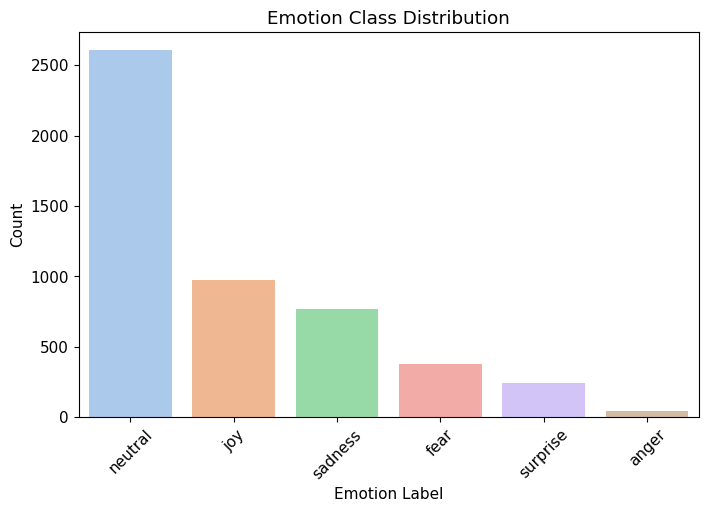

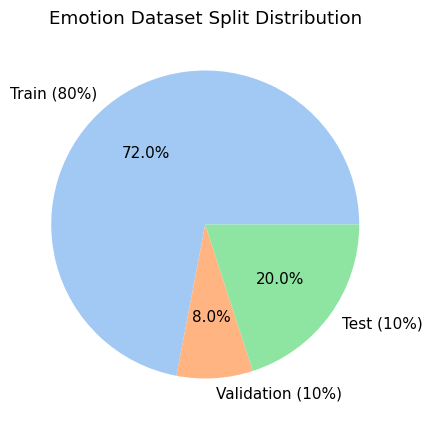

In [11]:
# ================================
# 💬 Emotion Detection: Distribution & Split Visualization
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Bar Plot (Emotion Distribution)
plt.figure(figsize=(8,5))
sns.barplot(x=df["emotion"].value_counts().index,
            y=df["emotion"].value_counts().values,
            palette="pastel")
plt.title("Emotion Class Distribution")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# ---- Pie Chart (Train/Val/Test Split)
split_sizes = [len(train_df), len(val_df), len(test_df)]
split_labels = ['Train (80%)', 'Validation (10%)', 'Test (10%)']

plt.figure(figsize=(5,5))
plt.pie(split_sizes, labels=split_labels, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Emotion Dataset Split Distribution")
plt.show()
